In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv


In [2]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report


In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4') 
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_dat

In [4]:
data = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv')
data.sample(50)
test_data = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv')
test_labels = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv')
merged_data = pd.merge(test_data, test_labels, on='id')

# Filter rows where toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate' are not -1
filtered_test_data = merged_data[
    (merged_data['toxic'] != -1) &
    (merged_data['severe_toxic'] != -1) &
    (merged_data['obscene'] != -1) &
    (merged_data['threat'] != -1) &
    (merged_data['insult'] != -1) &
    (merged_data['identity_hate'] != -1)
]

filtered_test_data.to_csv('/kaggle/working/cleaned_test_data.csv', index=False)
filtered_test_data.sample(200)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
20560,227309a5d899162e,:I'm too lazy to have a sock puppet. I wouldn'...,0,0,0,0,0,0
32009,35359180a1b7c8ea,:Salaam Nd. Mohamed. Ahsante sana kwa ujumbe y...,0,0,0,0,0,0
21312,23ad1f326f59bd15,WHAT ARE DEAF PEOPLE THERE PEOPLE WHO CAN'T HE...,0,0,0,0,0,0
58760,61bc3691f9633f62,forgot to sign,0,0,0,0,0,0
58887,61ef06945c627ab2,"== Hate and blood == \n\n Yeah, go ahead and b...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
127715,d56a3574c74997d4,== Non-breaking hyphen == \n\n Thanks for the ...,0,0,0,0,0,0
112960,bc890eacbd484023,: HE EXTERMINATED NEARLY ALL OF HERERO TRIBE!!!,0,0,0,0,0,0
50648,540eb7ed93506d97,* Describe Vigenère's version of the cipher in...,0,0,0,0,0,0
110434,b82c7109c01b4171,== Vandalism on FIFA Club World Cup == \n\n On...,0,0,0,0,0,0


In [5]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [6]:
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-z\s]', '', text)  # Remove punctuation and numbers
    text = text.strip()  # Remove leading and trailing whitespaces
    tokens = text.split()  # Tokenize the text by splitting on whitespace
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize the tokens
    cleaned_text = ' '.join(tokens)  # Join tokens back into a single string
    return cleaned_text

In [7]:
data['cleaned_comment'] = data['comment_text'].apply(clean_text)
data['is_toxic'] = data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].max(axis=1)
filtered_test_data['cleaned_comment'] = filtered_test_data['comment_text'].apply(clean_text)
filtered_test_data['is_toxic'] = filtered_test_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].max(axis=1)


/tmp/ipykernel_35/3316149774.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_test_data['cleaned_comment'] = filtered_test_data['comment_text'].apply(clean_text)
/tmp/ipykernel_35/3316149774.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_test_data['is_toxic'] = filtered_test_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].max(axis=1)


In [8]:
data['is_toxic'].unique()


array([0, 1])

In [9]:
filtered_test_data['is_toxic'].unique()

array([0, 1])

In [10]:
data.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned_comment,is_toxic
126920,a6cc73a3e10141e8,Your Created Page Eeee\n\n As they say in the...,0,0,0,0,0,0,created page eeee say movie oh behave seriousl...,0
8876,179297203bb87129,Someone's been bad! \n\nNaughty! You should be...,0,0,0,0,0,0,someone bad naughty ashamed,0
32819,5755717a4353c136,"""\n\n Personal Attack \nYou made a personal at...",1,0,0,0,0,0,personal attack made personal attack comment l...,1
52697,8ce10729cd237f83,If it is a problem with me doing so and it is ...,0,0,0,0,0,0,problem violation definitely may ask asked wri...,0
155364,bcafadf62bf9e97f,]\nI've had enough of your misbehavior. I don...,0,0,0,0,0,0,ive enough misbehavior dont endlessly debate p...,0


In [11]:

filtered_test_data.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned_comment,is_toxic
112220,bb474a6cddeb82a0,== Solidarity with the Russian Wikipedia black...,0,0,0,0,0,0,solidarity russian wikipedia blackout hi excus...,0
1707,02eb04316b23ced8,== Requested hint == \n\n No characters in the...,0,0,0,0,0,0,requested hint character original text replace...,0
105683,b06ff3f639ca3853,""" \n\n You must stop calling PopCrush unreliab...",0,0,0,0,0,0,must stop calling popcrush unreliable zero sou...,0
65346,6cbee95113456fff,"This page is a fucking joke, clearly written b...",1,0,1,0,0,0,page fucking joke clearly written people lioni...,1
57830,603a0dc7dbdcc4e4,Sorry so long before I got back to this. The i...,0,0,0,0,0,0,sorry long got back image jimmy wright taken c...,0


In [12]:
vectorizer = TfidfVectorizer(max_features=10000)
X = vectorizer.fit_transform(data['cleaned_comment'])
y = data['is_toxic']
X_test = vectorizer.transform(filtered_test_data['cleaned_comment'])
y_test= filtered_test_data['is_toxic']

In [13]:
# Count occurrences of each distinct value in y_test
label_counts = y_test.value_counts()

# Print the counts
print("Label Distribution in Test Data:")
print(label_counts)

Label Distribution in Test Data:
is_toxic
0    57735
1     6243
Name: count, dtype: int64


In [14]:
import pandas as pd
from tabulate import tabulate

# Count occurrences of each distinct value in y_test
label_counts = y_test.value_counts()

# Convert Series to DataFrame
label_counts_df = pd.DataFrame(label_counts).reset_index()
label_counts_df.columns = ['Label', 'Count']

# Print DataFrame with borders using tabulate
print("Label Distribution in Test Data:")
print(tabulate(label_counts_df, headers='keys', tablefmt='grid', showindex=False))


Label Distribution in Test Data:
+---------+---------+
|   Label |   Count |
+=========+=========+
|       0 |   57735 |
+---------+---------+
|       1 |    6243 |
+---------+---------+


In [15]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X,y)
label_counts_test = y_train_resampled.value_counts()
print("Label Distribution in Train Data After SMOTE:")
print(label_counts_test)


Label Distribution in Train Data After SMOTE:
is_toxic
0    143346
1    143346
Name: count, dtype: int64


In [16]:
nb = MultinomialNB()
nb.fit(X_train_resampled,y_train_resampled)

MultinomialNB()

In [17]:
y_pred = nb.predict(X_test)

In [18]:
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
y_prob = nb.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_prob)
ks_statistic, _ = ks_2samp(y_prob[y_test == 1], y_prob[y_test == 0])

In [19]:
print("auc",auc)
print(f"KS Statistic: {ks_statistic:.2f}")

auc 0.9448179522336343
KS Statistic: 0.75


In [20]:
print(classification_report(filtered_test_data['is_toxic'], y_pred))

              precision    recall  f1-score   support

           0       0.99      0.84      0.91     57735
           1       0.38      0.91      0.54      6243

    accuracy                           0.85     63978
   macro avg       0.68      0.87      0.72     63978
weighted avg       0.93      0.85      0.87     63978



Accuracy for all alpha values:
Alpha: 0.1, F1-score: 0.8971
Alpha: 0.5, F1-score: 0.8972
Alpha: 1.0, F1-score: 0.8975
Alpha: 1.5, F1-score: 0.8974
Alpha: 2.0, F1-score: 0.8976

Best parameters found:  {'alpha': 2.0}
Best F1 score found:  0.8976362568448485

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.84      0.91     57735
           1       0.38      0.91      0.53      6243

    accuracy                           0.84     63978
   macro avg       0.68      0.88      0.72     63978
weighted avg       0.93      0.84      0.87     63978


Accuracy of the best model: 0.8444
Best Model ROC AUC: 0.946021657359213
Best Model KS Statistic: 0.75


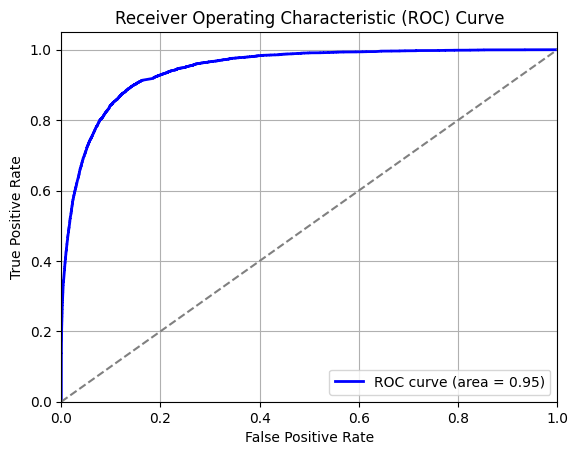

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy.stats import ks_2samp

# Define the parameter grid with different alpha values
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 1.5, 2.0],  # Numeric values for alpha
}

# Initialize MultinomialNB classifier
nb = MultinomialNB()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=nb, param_grid=param_grid, cv=5, scoring='f1')

# Fit GridSearchCV on resampled data
grid_search.fit(X_train_resampled, y_train_resampled)

# Print accuracy for all alpha values from cv_results_
print("Accuracy for all alpha values:")
for i in range(len(grid_search.cv_results_['params'])):
    alpha = grid_search.cv_results_['params'][i]['alpha']
    mean_score = grid_search.cv_results_['mean_test_score'][i]
    print(f"Alpha: {alpha}, F1-score: {mean_score:.4f}")

# Print the best parameters and the best score
print("\nBest parameters found: ", grid_search.best_params_)
print("Best F1 score found: ", grid_search.best_score_)

# Predict with the best model
best_nb = grid_search.best_estimator_
y_pred_best = best_nb.predict(X_test)

# Evaluate the best model
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))

# Calculate and print accuracy for the best model
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"\nAccuracy of the best model: {accuracy_best:.4f}")

# Print ROC AUC and KS Statistic for the best model
y_prob_best = best_nb.predict_proba(X_test)[:, 1]
auc_best = roc_auc_score(y_test, y_prob_best)  # Corrected here
ks_statistic_best, _ = ks_2samp(y_prob_best[y_test == 1], y_prob_best[y_test == 0])
print("Best Model ROC AUC:", auc_best)
print(f"Best Model KS Statistic: {ks_statistic_best:.2f}")
# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob_best)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
